# ADataset Fashion MNIST
Fashion MNIST es un conjunto de datos que consiste en 70,000 imágenes en escala de grises de 28x28 píxeles, divididas en 60,000 ejemplos de entrenamiento y 10,000 ejemplos de prueba. Contiene 10 categorías de prendas de vestir.

##Arquitectura del Ensamble
El proyecto implementa un ensamble heterogéneo de 5 modelos mediante la técnica de stacking:

Dos Redes Convolucionales (CNN): Arquitecturas especializadas en el procesamiento de datos con estructura de rejilla, particularmente efectivas para imágenes por su capacidad de capturar características espaciales jerárquicas.
Una Red Neuronal Multilayer Perceptron (MLP): Red neuronal completamente conectada que sirve como referencia baseline.
Random Forest: Algoritmo de aprendizaje por conjunto basado en árboles de decisión que promedia múltiples árboles para reducir el sobreajuste y mejorar la precisión.
K-Nearest Neighbors (KNN): Algoritmo no paramétrico que clasifica basándose en la similitud con ejemplos de entrenamiento.
Modelo de Stacking: Una red neuronal que combina las predicciones de los modelos anteriores para generar la predicción final.

Detalles Técnicos del Ensamble

Entrenamiento por Separado: Cada modelo base (2 CNNs, MLP, Random Forest, KNN) se entrena individualmente con el conjunto de entrenamiento de Fashion MNIST.
Generación de Meta-características: Los modelos base generan predicciones (probabilidades para cada clase) que sirven como entrada para el meta-modelo.
Meta-modelo: La red neuronal de stacking se entrena con estas meta-características para aprender la combinación óptima de las predicciones de los modelos base.

Análisis de Confusión y Mejoras
El análisis de la matriz de confusión muestra que las camisas (clase 6) presentan la mayor tasa de clasificación errónea, confundiéndose principalmente con camisetas/tops (clase 0) y suéteres (clase 2) debido a sus similitudes visuales.
Propuesta de Mejora
Para abordar esta limitación específica, se recomienda implementar data augmentation dirigida a las clases problemáticas:

Transformaciones Específicas para Camisas:

Rotaciones ligeras (±10°)
Zoom aleatorio (0.9-1.1)
Desplazamientos horizontales y verticales
Variaciones sutiles de brillo y contraste
Transformaciones elásticas para simular diferentes pliegues y texturas


Aumento Selectivo: Generar más ejemplos sintéticos específicamente para la clase "camisa" para equilibrar el rendimiento.
Ponderación de Clases: Ajustar los pesos de las clases en la función de pérdida para penalizar más los errores en la clase "camisa".

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.models import clone_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from keras.utils import to_categorical



prendas = ['Camiseta/Top', 'Pantalón', 'Suéter', 'Vestido', 'Abrigo',
               'Sandalia', 'Camisa', 'Zapatilla deportiva', 'Bolso', 'Botín']



df = pd.read_csv("mnist_fashion_train.csv")


df.head()



,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,119,114,130,76,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,33,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


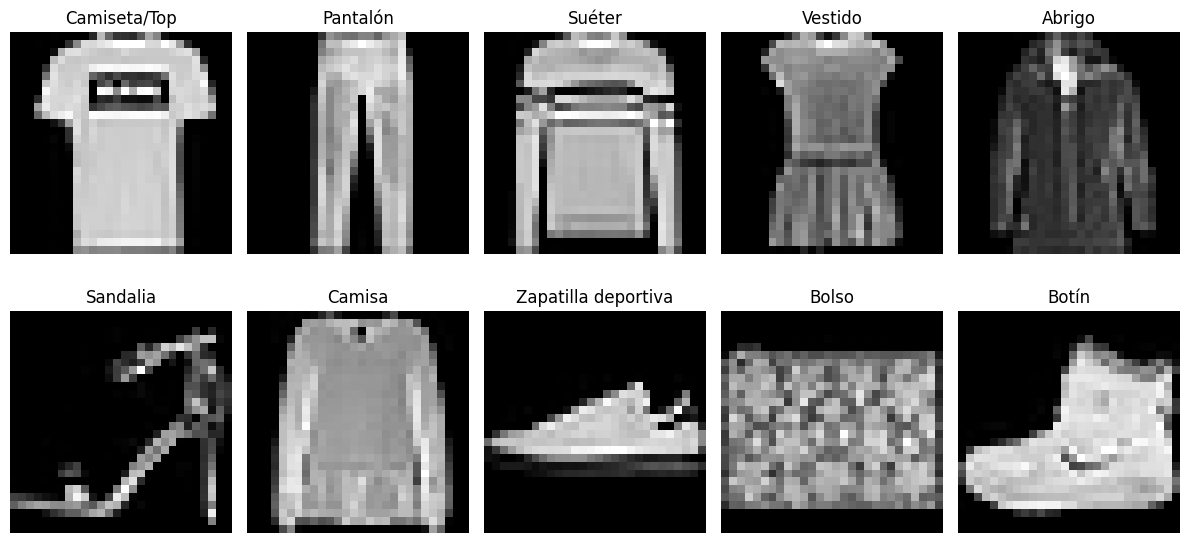

In [ ]:

primeras_apariciones = df.groupby("label").first().reset_index()

fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    etiqueta = primeras_apariciones.loc[i, "label"]
    prenda = prendas[etiqueta]
    imagen = primeras_apariciones.iloc[i, 1:].values.reshape(28, 28)

    ax.imshow(imagen, cmap="gray")
    ax.set_title(prenda)
    ax.axis("off")

plt.tight_layout()
plt.show()

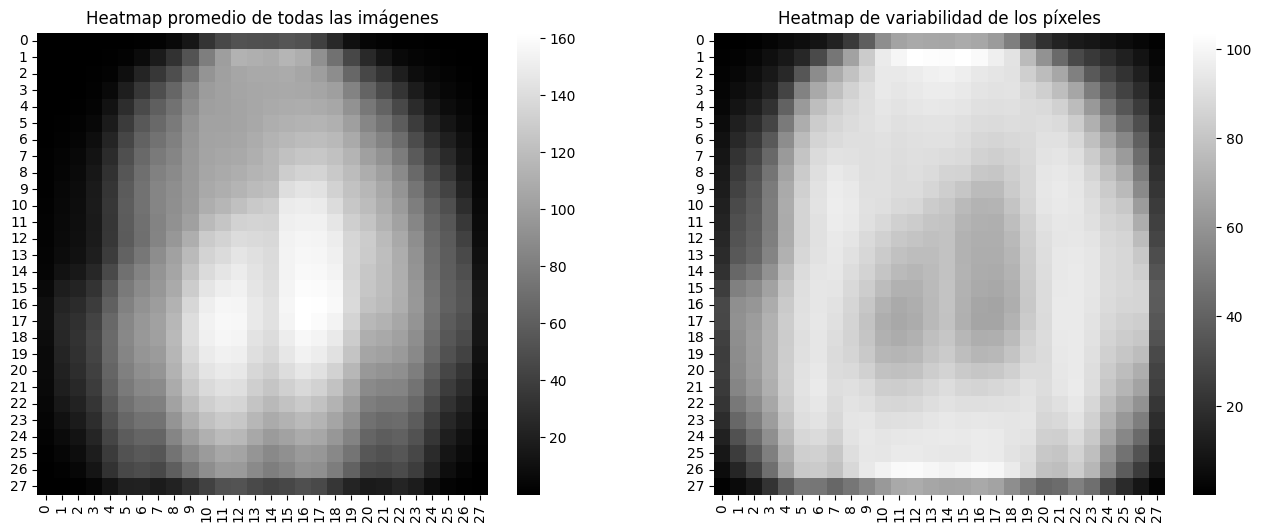

In [ ]:
# Calcular el heatmap promedio
heatmap = df.iloc[:, 1:].mean(axis=0).values.reshape(28, 28)

# Calcular el heatmap de variabilidad
heatmap_var = df.iloc[:, 1:].std(axis=0).values.reshape(28, 28)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(heatmap, cmap="gray", cbar=True, ax=axes[0])
axes[0].set_title("Heatmap promedio de todas las imágenes")

sns.heatmap(heatmap_var, cmap="gray", cbar=True, ax=axes[1])
axes[1].set_title("Heatmap de variabilidad de los píxeles")

plt.show()

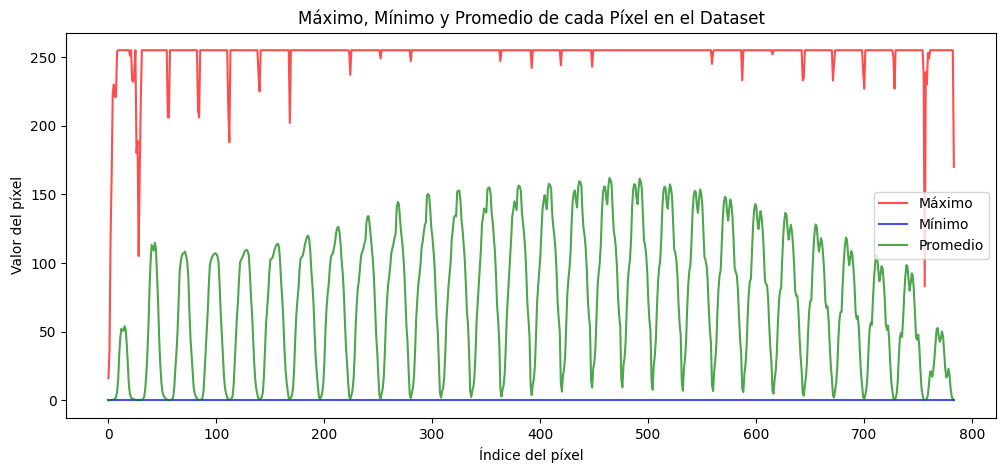

In [ ]:
datos_imagenes = df.iloc[:, 1:].values
max_por_columna = np.max(datos_imagenes, axis=0)
min_por_columna = np.min(datos_imagenes, axis=0)




# Cargar datos (ignorando la columna de etiquetas si está presente)
datos_imagenes = df.iloc[:, 1:].values  # Tomar solo los píxeles

# Calcular máximos, mínimos y promedios de cada píxel
max_por_pixel = np.max(datos_imagenes, axis=0)
min_por_pixel = np.min(datos_imagenes, axis=0)
promedio_por_pixel = np.mean(datos_imagenes, axis=0)

# Crear el gráfico
plt.figure(figsize=(12, 5))
x = np.arange(len(max_por_pixel))  # Índices de píxeles

plt.plot(x, max_por_pixel, label="Máximo", color="red", alpha=0.7)
plt.plot(x, min_por_pixel, label="Mínimo", color="blue", alpha=0.7)
plt.plot(x, promedio_por_pixel, label="Promedio", color="green", alpha=0.7)

# Configuración del gráfico
plt.legend()
plt.xlabel("Índice del píxel")
plt.ylabel("Valor del píxel")
plt.title("Máximo, Mínimo y Promedio de cada Píxel en el Dataset")
plt.show()

Se puede ver que no hay pixeles que nunca son pintados o que siempre son pintados que serían pixeles triviales.Aunque si hay pixeles que en promedio están ḿas pintados que otros.

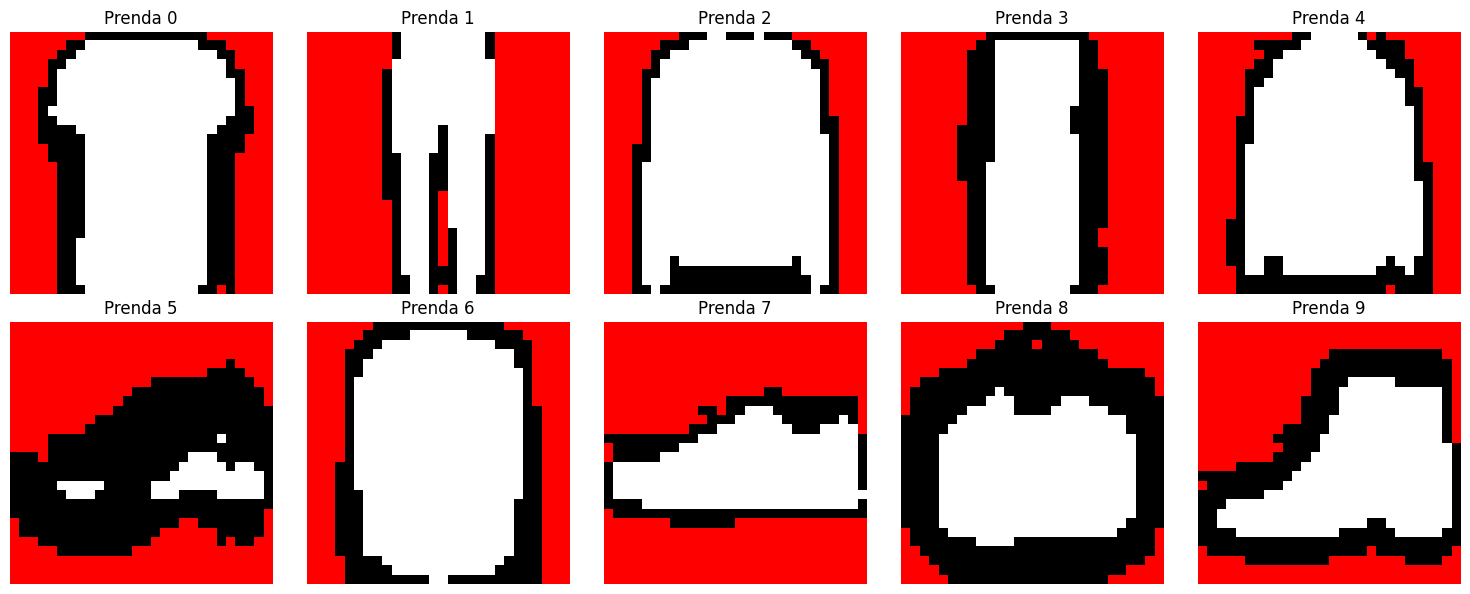

Píxeles representativos guardados en el array 'pixelesRepresentativos'
Prenda 0: 629 píxeles representativos (629 poco frecuentes, 0 muy frecuentes)
Prenda 1: 697 píxeles representativos (697 poco frecuentes, 0 muy frecuentes)
Prenda 2: 661 píxeles representativos (661 poco frecuentes, 0 muy frecuentes)
Prenda 3: 622 píxeles representativos (622 poco frecuentes, 0 muy frecuentes)
Prenda 4: 650 píxeles representativos (650 poco frecuentes, 0 muy frecuentes)
Prenda 5: 423 píxeles representativos (423 poco frecuentes, 0 muy frecuentes)
Prenda 6: 626 píxeles representativos (626 poco frecuentes, 0 muy frecuentes)
Prenda 7: 668 píxeles representativos (668 poco frecuentes, 0 muy frecuentes)
Prenda 8: 424 píxeles representativos (424 poco frecuentes, 0 muy frecuentes)
Prenda 9: 567 píxeles representativos (567 poco frecuentes, 0 muy frecuentes)


In [ ]:
pixelesRepresentativos = []
num_prendas = 10
pixelesRepresentativos = [None] * num_prendas

# Preparar la figura para visualización (2 filas x 5 columnas)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()  # Convertir a array 1D para fácil indexación

# Procesar cada prenda
for n in range(num_prendas):
    # Filtrar las imágenes de la Prenda n
    PRENDA = df[df.iloc[:, 0] == n].iloc[:, 1:].values

    # Si no hay imágenes para esta prenda, continuar con la siguiente
    if PRENDA.shape[0] == 0:
        pixelesRepresentativos[n] = np.array([])
        axes[n].text(0.5, 0.5, f"No hay datos\npara prenda {n}",
                    ha='center', va='center')
        axes[n].axis('off')
        continue

    # Calcular porcentaje de píxeles no cero
    nonzero_counts = np.count_nonzero(PRENDA, axis=0)
    total_imagenes = PRENDA.shape[0]
    porcentaje = nonzero_counts / total_imagenes

    # Obtener índices de píxeles poco y muy frecuentes
    pixeles_poco_frecuentes = np.where(porcentaje < 0.25)[0]
    pixeles_muy_frecuentes = np.where(porcentaje > 0.75)[0]

    # Guardar en el array global
    pixelesRepresentativos[n] = np.concatenate([pixeles_poco_frecuentes, pixeles_muy_frecuentes])

    # Visualizar la matriz de píxeles representativos
    porcentaje_reshaped = porcentaje.reshape(28, 28)
    imagen_color = np.zeros((28, 28, 3), dtype=np.uint8)

    # Asignar colores
    imagen_color[porcentaje_reshaped < 0.25] = [255, 0, 0]  # Rojo para poco frecuentes
    imagen_color[porcentaje_reshaped > 0.75] = [255, 255, 255]  # Blanco para muy frecuentes

    # Mostrar imagen en el subplot correspondiente
    axes[n].imshow(imagen_color)
    axes[n].set_title(f"Prenda {n}")
    axes[n].axis("off")

plt.tight_layout()
plt.show()

# Mostrar información sobre los píxeles guardados
print("Píxeles representativos guardados en el array 'pixelesRepresentativos'")
for i in range(num_prendas):
    if len(pixelesRepresentativos[i]) > 0:
        poco_freq_count = np.sum(pixelesRepresentativos[i] < 784)  # Asumiendo que hay una separación clara
        print(f"Prenda {i}: {len(pixelesRepresentativos[i])} píxeles representativos "
              f"({poco_freq_count} poco frecuentes, {len(pixelesRepresentativos[i]) - poco_freq_count} muy frecuentes)")


In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

# División en 80% training y 20% validation con un seed fijo
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training: {X_train.shape}, Validation: {X_val.shape}")


Training: (48000, 784), Validation: (12000, 784)


In [ ]:
# Contar ocurrencias en el conjunto completo
print("Distribución en y:")
print(pd.Series(y).value_counts().sort_index())

# Contar ocurrencias en el conjunto de entrenamiento
print("\nDistribución en y_train:")
print(pd.Series(y_train).value_counts().sort_index())

# Contar ocurrencias en el conjunto de validación
print("\nDistribución en y_val:")
print(pd.Series(y_val).value_counts().sort_index())

Distribución en y:
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: count, dtype: int64

Distribución en y_train:
0    4798
1    4781
2    4795
3    4816
4    4798
5    4789
6    4782
7    4841
8    4803
9    4797
Name: count, dtype: int64

Distribución en y_val:
0    1202
1    1219
2    1205
3    1184
4    1202
5    1211
6    1218
7    1159
8    1197
9    1203
Name: count, dtype: int64


In [ ]:
# Volver a definir y compilar el modelo
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(28,28,1),
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")
])

# Compilar con Adam
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
X_train = X_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
X_val = X_val.reshape(-1, 28, 28, 1).astype("float32") / 255.0




model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))


Epoch 1/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 60s 39ms/step - accuracy: 0.6756 - loss: 1.0872 - val_accuracy: 0.8337 - val_loss: 0.6003
Epoch 2/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 80s 37ms/step - accuracy: 0.8130 - loss: 0.6536 - val_accuracy: 0.8637 - val_loss: 0.5206
Epoch 3/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 82s 37ms/step - accuracy: 0.8342 - loss: 0.5968 - val_accuracy: 0.8728 - val_loss: 0.4935
Epoch 4/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 55s 37ms/step - accuracy: 0.8449 - loss: 0.5745 - val_accuracy: 0.8725 - val_loss: 0.4882
Epoch 5/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 82s 37ms/step - accuracy: 0.8500 - loss: 0.5502 - val_accuracy: 0.8767 - val_loss: 0.4747
Epoch 6/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 57s 38ms/step - accuracy: 0.8540 - loss: 0.5405 - val_accuracy: 0.8774 - val_loss: 0.4742
Epoch 7/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 55s 37ms/step - accuracy: 0.8639 - loss: 0.5319 - val_accuracy: 0.8854 - val_loss: 0.4546
Epoch 8/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 87s 40ms/step - accuracy: 0.8624 -

375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


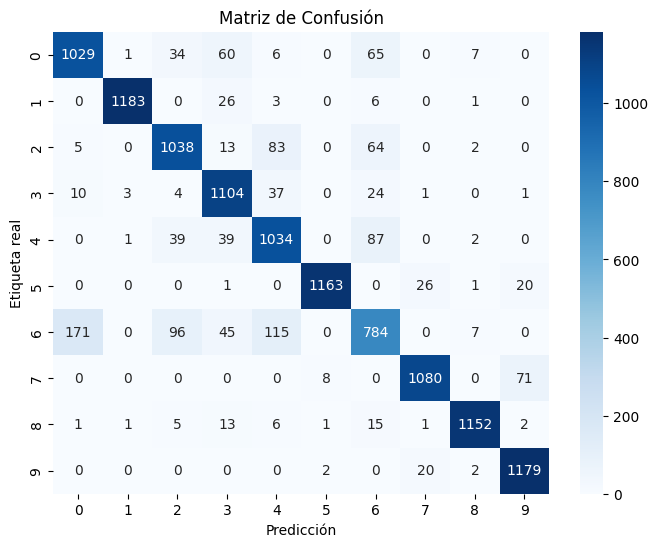

In [ ]:


def confMatrix(model, xval, yval):
    # Obtener predicciones en el conjunto de validación
    y_pred = model.predict(xval)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir probabilidades en clases

    # Crear la matriz de confusión
    cm = confusion_matrix(yval, y_pred_classes)

    # Graficar la matriz de confusión
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicción")
    plt.ylabel("Etiqueta real")
    plt.title("Matriz de Confusión")
    plt.show()

confMatrix(model, X_val, y_val)

In [ ]:
# Filtrar por categoría
extra_6 = X[y == 6][:2000]  # 2000 ejemplos extra de la categoría 6
extra_2 = X[y == 2][:600]
extra_0 = X[y == 0][:600]
extra_4 = X[y == 4][:400]
extra_3 = X[y == 3][:200]

extra_y6 = np.full((2000,), 6)  # Etiquetas correspondientes
extra_y2 = np.full((600,), 2)
extra_y0 = np.full((600,), 0)
extra_y4 = np.full((400,), 4)
extra_y3 = np.full((200,), 3)

# Concatenar los extras a los datos originales
X_extended = np.concatenate([X, extra_6, extra_2, extra_0, extra_4,extra_3])
y_extended = np.concatenate([y, extra_y6, extra_y2, extra_y0, extra_y4, extra_y3])

# Hacer el split normalmente
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_extended, y_extended, test_size=0.2, random_state=99)

In [ ]:
# Contar ocurrencias en el conjunto completo
print("Distribución en y:")
print(pd.Series(y).value_counts().sort_index())

# Contar ocurrencias en el conjunto de entrenamiento
print("\nDistribución en y_train2:")
print(pd.Series(y_train2).value_counts().sort_index())

# Contar ocurrencias en el conjunto de validación
print("\nDistribución en y_val:")
print(pd.Series(y_val2).value_counts().sort_index())

Distribución en y:
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: count, dtype: int64

Distribución en y_train2:
0    5261
1    4806
2    5295
3    4971
4    5153
5    4760
6    6379
7    4824
8    4792
9    4799
Name: count, dtype: int64

Distribución en y_val:
0    1339
1    1194
2    1305
3    1229
4    1247
5    1240
6    1621
7    1176
8    1208
9    1201
Name: count, dtype: int64


In [ ]:
model2 = models.Sequential([
    # Primera capa convolucional con más filtros
    layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                  input_shape=(28, 28, 1),
                  kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Segunda capa convolucional más ancha
    layers.Conv2D(128, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # Tercera capa convolucional para extraer características de alto nivel
    layers.Conv2D(256, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(), # En lugar de Flatten
    layers.Dropout(0.4),

    # Capa densa con más neuronas
    layers.Dense(256, activation='relu',
                kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Capa de salida (10 clases para Fashion MNIST)
    layers.Dense(10, activation='softmax')
])

# Compilar model2 con Adam optimizado
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenar model2 con callbacks para mejor rendimiento
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
]


# Normalizar los nuevos datos
X_train2 = X_train2.reshape(-1, 28, 28, 1).astype("float32") / 255.0
X_val2 = X_val2.reshape(-1, 28, 28, 1).astype("float32") / 255.0

# Entrenar el nuevo modelo
model2.fit(X_train2, y_train2, epochs=30, validation_data=(X_val2, y_val2))



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 379s 234ms/step - accuracy: 0.6571 - loss: 1.4165 - val_accuracy: 0.7946 - val_loss: 0.8819
Epoch 2/30
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 419s 257ms/step - accuracy: 0.8319 - loss: 0.7588 - val_accuracy: 0.8649 - val_loss: 0.6184
Epoch 3/30
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 405s 234ms/step - accuracy: 0.8527 - loss: 0.6597 - val_accuracy: 0.8510 - val_loss: 0.6442
Epoch 4/30
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 365s 224ms/step - accuracy: 0.8591 - loss: 0.6314 - val_accuracy: 0.8703 - val_loss: 0.6010
Epoch 5/30
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 383s 224ms/step - accuracy: 0.8640 - loss: 0.6350 - val_accuracy: 0.8963 - val_loss: 0.5397
Epoch 6/30
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 378s 222ms/step - accuracy: 0.8666 - loss: 0.6290 - val_accuracy: 0.8792 - val_loss: 0.5838
Epoch 7/30
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 356s 224ms/step - accuracy: 0.8685 - loss: 0.6249 - val_accuracy: 0.8886 - val_loss: 0.5586
Epoch 8/30
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 381s 223ms/step - ac

399/399 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step


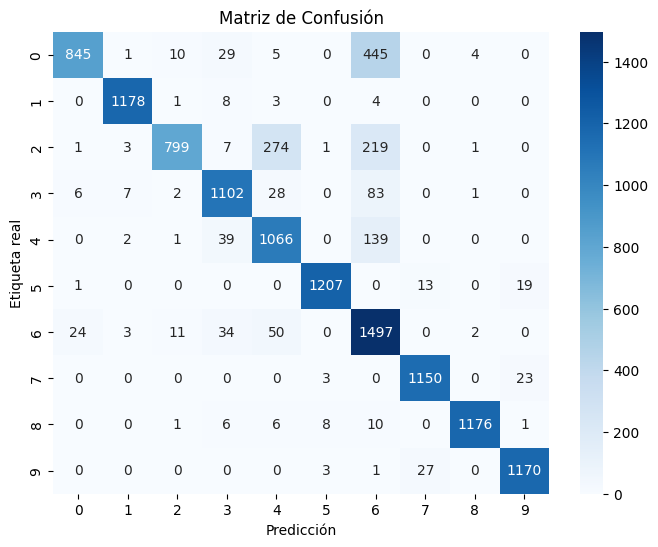

In [ ]:
confMatrix(model2, X_val2, y_val2)

In [ ]:
X_train3, X_val3, y_train3, y_val3 = train_test_split(X_extended, y_extended, test_size=0.2, random_state=3)

In [ ]:
# Definir el modelo MLP
model3 = models.Sequential([
    layers.Flatten(input_shape=(28, 28, 1)),
    layers.Dropout(0.2),  # Dropout en la entrada
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dropout(0.5),
    layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dropout(0.25),
    layers.Dense(10, activation="softmax")  # Capa de salida para 10 clases
])

# Compilar el modelo
model3.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])



X_train3 = X_train3.reshape(-1, 28, 28, 1).astype("float32") / 255.0
X_val3 = X_val3.reshape(-1, 28, 28, 1).astype("float32") / 255.0


model3.fit(X_train3, y_train3, epochs=50, validation_data=(X_val3, y_val3))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.6137 - loss: 1.0757 - val_accuracy: 0.8202 - val_loss: 0.5212
Epoch 2/50
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7819 - loss: 0.6432 - val_accuracy: 0.8399 - val_loss: 0.4853
Epoch 3/50
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7953 - loss: 0.5974 - val_accuracy: 0.8454 - val_loss: 0.4755
Epoch 4/50
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8062 - loss: 0.5807 - val_accuracy: 0.8421 - val_loss: 0.4787
Epoch 5/50
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8119 - loss: 0.5670 - val_accuracy: 0.8520 - val_loss: 0.4654
Epoch 6/50
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8157 - loss: 0.5598 - val_accuracy: 0.8511 - val_loss: 0.4564
Epoch 7/50
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8169 - loss: 0.5578 - val_accuracy: 0.8528 - val_loss: 0.4518
Epoch 8/50
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8130 - loss: 0.5

399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


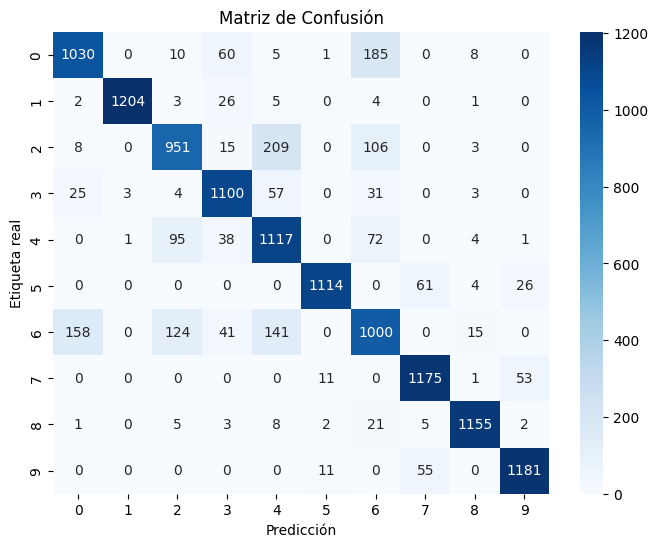

In [ ]:
confMatrix(model3, X_val3, y_val3)

In [ ]:
X_train4, X_val4, y_train4, y_val4 = train_test_split(X, y, test_size=0.2, random_state=50)


In [ ]:
"""

# Define el modelo de Random Forest
modelo_rf = RandomForestClassifier(random_state=42)

# Define el rango de hiperparámetros que quieres buscar
param_grid = {
    'n_estimators': [50, 100, 150],  # Número de árboles en el bosque
    'max_depth': [5, 10, 15, None],   # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],  # Mínimo número de muestras necesarias para dividir un nodo
    'min_samples_leaf': [1, 2, 4]     # Mínimo número de muestras necesarias para ser una hoja
}

# Configura el GridSearchCV con validación cruzada de 5 pliegues
grid_search = GridSearchCV(estimator=modelo_rf,
                           param_grid=param_grid,
                           cv=5,  # Número de pliegues en la validación cruzada
                           scoring='accuracy',  # Métrica de evaluación
                           n_jobs=-1,  # Usar todos los núcleos disponibles
                           verbose=2)  # Muestra información durante la búsqueda

# Realiza la búsqueda en rejilla
grid_search.fit(X_train4, y_train4)

# Imprime los mejores parámetros encontrados y el mejor score
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor precisión: {grid_search.best_score_:.4f}")


"""
modelo4 = RandomForestClassifier(n_estimators=100,  # Número de árboles en el bosque
                                 max_depth=10,      # Profundidad máxima de cada árbol
                                 random_state=42)   # Semilla para la reproducibilidad

# Realiza la validación cruzada con 5 pliegues
#scores = cross_val_score(modelo4, X_train4, y_train4, cv=5, scoring='accuracy')

# Ajusta el modelo en el conjunto de entrenamiento completo
calibrador = CalibratedClassifierCV(modelo4, method='sigmoid', cv='prefit')  # Usamos el método 'sigmoid' para calibrar
modelo4.fit(X_train4, y_train4)  # Entrenamos el modelo
calibrador.fit(X_train4, y_train4)  # Calibramos el modelo

# Predicción de probabilidades con el modelo calibrado
y_pred_proba = calibrador.predict_proba(X_val4)  # Devuelve las probabilidades para cada clase

# Convertir probabilidades a clases (usando np.argmax)
y_pred_classes = np.argmax(y_pred_proba, axis=1)




/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


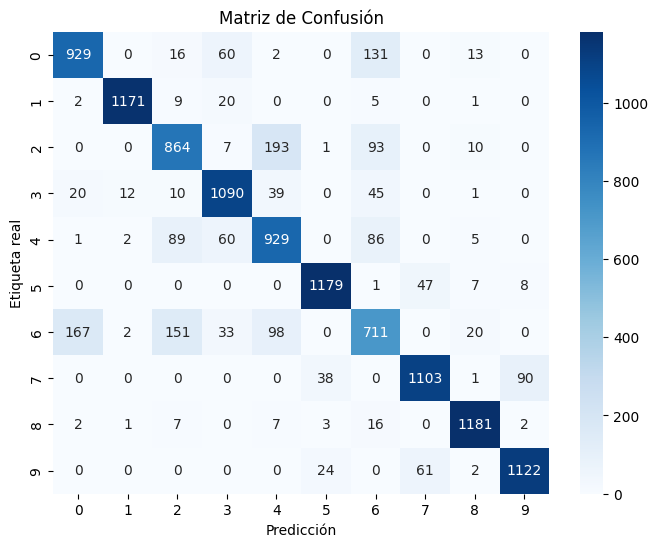

Precisión del modelo calibrado: 0.8566


In [ ]:
cm = confusion_matrix(y_val4, y_pred_classes)

# Graficar la matriz de confusión
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión")
plt.show()

# Opcional: Mostrar la precisión del modelo calibrado
print(f"Precisión del modelo calibrado: {calibrador.score(X_val4, y_val4):.4f}")

In [ ]:
X_train5, X_val5, y_train5, y_val5 = train_test_split(X, y, test_size=0.2, random_state=84)


In [ ]:
"""k_values = [1, 3, 5, 7, 9]

# Inicializar variables para rastrear el mejor modelo
best_k = None
best_score = 0
best_model = None

# Iterar sobre cada valor de k
for k in k_values:
    # Inicializar el modelo KNN con el valor actual de k
    modelo5 = KNeighborsClassifier(n_neighbors=k)

    # Realizar la validación cruzada con 5 pliegues
    scores = cross_val_score(modelo5, X_train5, y_train5, cv=5, scoring='accuracy')

    # Obtener la precisión media para este k
    mean_score = scores.mean()

    # Actualizar el mejor modelo si se encuentra una mayor precisión
    if mean_score > best_score:
        best_score = mean_score
        best_k = k
        best_model = modelo5

    # Imprimir los resultados de la validación cruzada para cada k
    print(f"\nResultados para k={k}:")
    print(f"Precisión por pliegue: {scores}")
    print(f"Precisión media: {mean_score:.4f}")
    print(f"Desviación estándar de la precisión: {scores.std():.4f}")

# Ahora entrenamos el mejor modelo
print(f"\nEl mejor valor de k es {best_k} con una precisión media de {best_score:.4f}")"""


k = 5
modelo5 = KNeighborsClassifier(n_neighbors=k)

modelo5.fit(X_train5, y_train5)

calibrador5 = CalibratedClassifierCV(modelo5, method='sigmoid', cv='prefit')
calibrador5.fit(X_train5, y_train5)

y_pred_proba = calibrador5.predict_proba(X_val5)

y_pred_classes = np.argmax(y_pred_proba, axis=1)


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


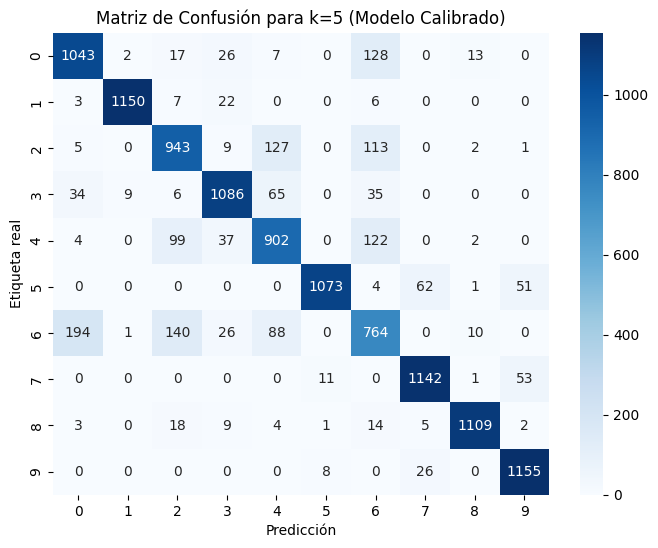

In [ ]:
# Crear la matriz de confusión
cm = confusion_matrix(y_val5, y_pred_classes)

# Graficar la matriz de confusión
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title(f"Matriz de Confusión para k={5} (Modelo Calibrado)")
plt.show()

AHORA TENGO QUE COMBINAR LOS MODELOS

In [ ]:
X_trainF, X_valF, y_trainF, y_valF = train_test_split(X, y, test_size=0.2, random_state=35)

In [ ]:
X_valF_reshaped = X_valF.reshape(-1, 28, 28, 1)

In [ ]:
predicción1 = model.predict(X_valF_reshaped)
prediccion2 = model2.predict(X_valF_reshaped)
prediccion3 = model3.predict(X_valF_reshaped)
prediccion4 = calibrador.predict(X_valF)
prediccion5 = calibrador5.predict(X_valF)

prediccion4 = to_categorical(prediccion4.astype(int), num_classes=10)
prediccion5 = to_categorical(prediccion5.astype(int), num_classes=10)

print(predicción1.shape)
print(prediccion2.shape)
print(prediccion3.shape)
print(prediccion4.shape)
print(prediccion5.shape)

peso_modelo1 = 1.5
peso_modelo2 = 1.2
peso_modelo3 = 1.1
peso_modelo4 = 1.0
peso_modelo5 = 1.0

predicciones = np.stack([
    predicción1 * peso_modelo1,
    prediccion2 * peso_modelo2,
    prediccion3 * peso_modelo3,
    prediccion4 * peso_modelo4,
    prediccion5 * peso_modelo5
], axis=1)


375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(12000, 10)
(12000, 10)
(12000, 10)
(12000, 10)
(12000, 10)


In [33]:
# Asumiendo que predicciones tiene forma (12000, 5, 10) después del stacking
# O posiblemente (12000, 5) si usaste la opción 2 que mencioné anteriormente

# Primero, verifica la forma de tus datos
print("Forma de predicciones:", predicciones.shape)

# Definir el meta-modelo según la forma de tus predicciones
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers

# Si predicciones tiene forma (n_samples, n_models, n_classes)
input_shape = predicciones.shape[1:]  # Obtenemos (n_models, n_classes) o (n_models,)

modelFinal = models.Sequential([
    layers.Flatten(input_shape=input_shape),  # Aplanar las predicciones si es necesario
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dropout(0.25),
    layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dropout(0.25),
    layers.Dense(10, activation="softmax")  # Mantén 10 si sigues teniendo 10 clases
])

# Compilar el modelo
modelFinal.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

# Entrenar el meta-modelo
modelFinal.fit(predicciones, y_valF, epochs=20, validation_split=0.2)

Forma de predicciones: (12000, 5, 10)
Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.6232 - loss: 1.3741 - val_accuracy: 0.9013 - val_loss: 0.3260
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8841 - loss: 0.4551 - val_accuracy: 0.8958 - val_loss: 0.3135
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8818 - loss: 0.4311 - val_accuracy: 0.9013 - val_loss: 0.3062
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8885 - loss: 0.4204 - val_accuracy: 0.9033 - val_loss: 0.3052
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8861 - loss: 0.4134 - val_accuracy: 0.9046 - val_loss: 0.3004
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8898 - loss: 0.3970 - val_accuracy: 0.9021 - val_loss: 0.3013
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8913 - loss: 0.3979 - val_accuracy: 0.9038 - val_loss: 0.3017
Epoch 8/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


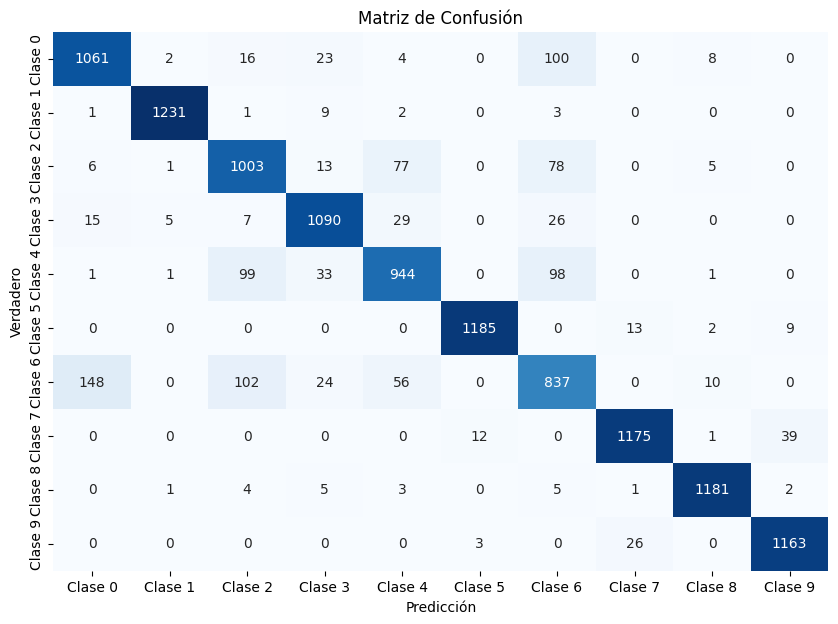

In [34]:
# Hacer las predicciones usando el modelo final
predicciones_finales = modelFinal.predict(predicciones)
# Convertir las probabilidades a clases (si es que el modelo devuelve probabilidades)
predicciones_clase = np.argmax(predicciones_finales, axis=1)

# Crear la matriz de confusión
matriz_confusion = confusion_matrix(y_valF, predicciones_clase)

# Visualizar la matriz de confusión usando un mapa de calor
plt.figure(figsize=(10, 7))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[f'Clase {i}' for i in range(10)],
            yticklabels=[f'Clase {i}' for i in range(10)])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()


## Evaluación del modelo con los datos reservados para el Tests.

In [39]:
test = pd.read_csv("mnist_fashion_test.csv")
Xtest = test.iloc[:, 1:].values
ytest = test.iloc[:, 0].values

Xtest_reshaped = Xtest.reshape(-1, 28, 28, 1)

In [40]:
predicciónTest1 = model.predict(Xtest_reshaped)
prediccionTest2 = model2.predict(Xtest_reshaped)
prediccionTest3 = model3.predict(Xtest_reshaped)
prediccionTest4 = calibrador.predict(Xtest)
prediccionTest5 = calibrador5.predict(Xtest)

prediccionTest4 = to_categorical(prediccionTest4.astype(int), num_classes=10)
prediccionTest5 = to_categorical(prediccionTest5.astype(int), num_classes=10)

print(predicciónTest1.shape)
print(prediccionTest2.shape)
print(prediccionTest3.shape)
print(prediccionTest4.shape)
print(prediccionTest5.shape)

peso_modelo1 = 1.5
peso_modelo2 = 1.2
peso_modelo3 = 1.1
peso_modelo4 = 1.0
peso_modelo5 = 1.0

prediccionesTest = np.stack([
    predicciónTest1 * peso_modelo1,
    prediccionTest2 * peso_modelo2,
    prediccionTest3 * peso_modelo3,
    prediccionTest4 * peso_modelo4,
    prediccionTest5 * peso_modelo5
], axis=1)


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(10000, 10)
(10000, 10)
(10000, 10)
(10000, 10)
(10000, 10)


In [41]:
prediccionesTest_finales = modelFinal.predict(prediccionesTest)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


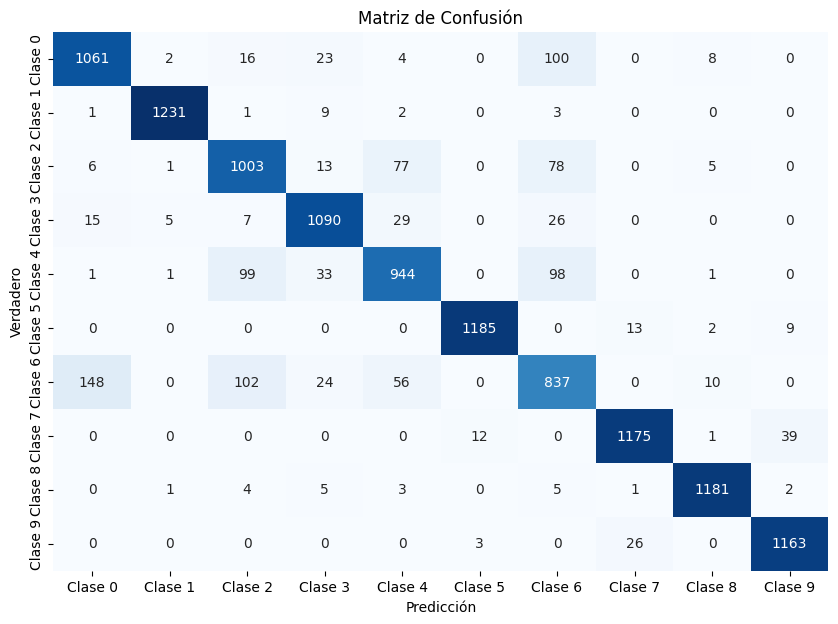

In [42]:
# Convertir las probabilidades a clases (si es que el modelo devuelve probabilidades)
predicciones_clase = np.argmax(predicciones_finales, axis=1)

# Crear la matriz de confusión
matriz_confusion = confusion_matrix(y_valF, predicciones_clase)

# Visualizar la matriz de confusión usando un mapa de calor
plt.figure(figsize=(10, 7))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[f'Clase {i}' for i in range(10)],
            yticklabels=[f'Clase {i}' for i in range(10)])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()


Accuracy: 0.9058
Precision: 0.9056
Recall: 0.9058
F1-score: 0.9056

Reporte de clasificación detallado:
              precision    recall  f1-score   support

     Clase 0       0.86      0.87      0.87      1214
     Clase 1       0.99      0.99      0.99      1247
     Clase 2       0.81      0.85      0.83      1183
     Clase 3       0.91      0.93      0.92      1172
     Clase 4       0.85      0.80      0.82      1177
     Clase 5       0.99      0.98      0.98      1209
     Clase 6       0.73      0.71      0.72      1177
     Clase 7       0.97      0.96      0.96      1227
     Clase 8       0.98      0.98      0.98      1202
     Clase 9       0.96      0.98      0.97      1192

    accuracy                           0.91     12000
   macro avg       0.90      0.90      0.90     12000
weighted avg       0.91      0.91      0.91     12000



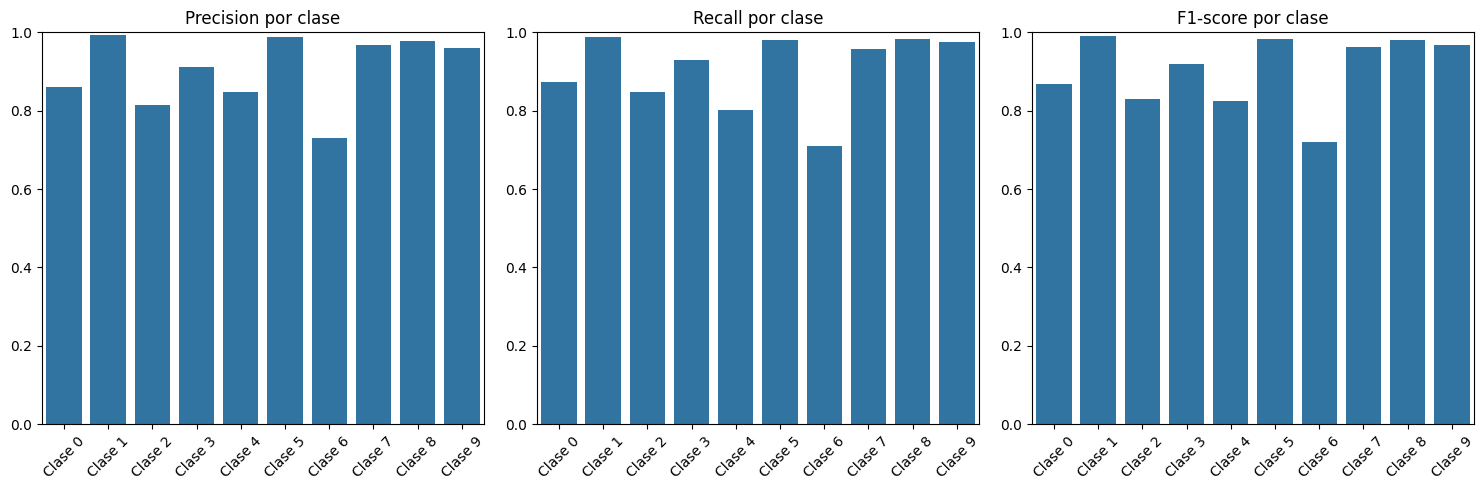

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Calcular métricas básicas
accuracy = accuracy_score(y_valF, predicciones_clase)
precision = precision_score(y_valF, predicciones_clase, average='weighted')
recall = recall_score(y_valF, predicciones_clase, average='weighted')
f1 = f1_score(y_valF, predicciones_clase, average='weighted')

# Imprimir resultados
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Generar un reporte de clasificación detallado
print("\nReporte de clasificación detallado:")
print(classification_report(y_valF, predicciones_clase,
                          target_names=[f'Clase {i}' for i in range(10)]))

# Calcular métricas por clase
precision_por_clase = precision_score(y_valF, predicciones_clase, average=None)
recall_por_clase = recall_score(y_valF, predicciones_clase, average=None)
f1_por_clase = f1_score(y_valF, predicciones_clase, average=None)

# Visualizar métricas por clase
plt.figure(figsize=(15, 5))

# Precision por clase
plt.subplot(1, 3, 1)
sns.barplot(x=[f'Clase {i}' for i in range(10)], y=precision_por_clase)
plt.title('Precision por clase')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Recall por clase
plt.subplot(1, 3, 2)
sns.barplot(x=[f'Clase {i}' for i in range(10)], y=recall_por_clase)
plt.title('Recall por clase')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# F1-score por clase
plt.subplot(1, 3, 3)
sns.barplot(x=[f'Clase {i}' for i in range(10)], y=f1_por_clase)
plt.title('F1-score por clase')
plt.ylim(0, 1)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()